In [26]:
import networkx as nx
import json

In [27]:
with open("./data/synonyms.json", "r", encoding="utf-8") as f:
    net = json.load(f)

In [28]:
# g = nx.from_dict_of_dicts(net)
g = nx.Graph(net)

In [29]:
# edges = nx.get_edge_attributes(g, "weight")
edges = [g.get_edge_data(u, v).get("weight", 0.5) for u, v in g.edges()]

colDict = {
    0: "#ff00ff",
    1: "#ff0000",
    2: "#00ff00",
    3: "#0000ff"
}

depth = nx.shortest_path_length(g, "flood")

nodeCols = [colDict.get(val, "#00ffff") for key, val in depth.items()]

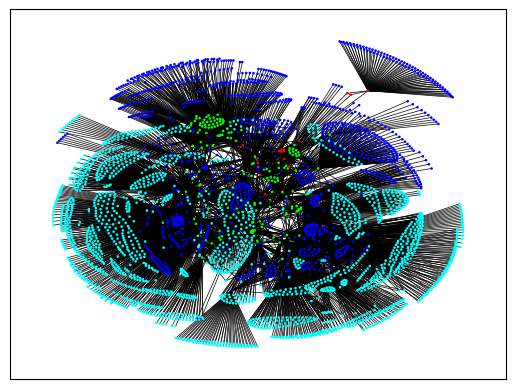

In [30]:
# edges = nx.get_edge_attributes(g, "weight")

pos = nx.kamada_kawai_layout(g)
# nx.draw(g, pos=pos)
nx.draw_networkx_edges(g, pos, width=edges)
nx.draw_networkx_nodes(g, pos, node_color=nodeCols, node_size=0.75)
# nx.draw_networkx_labels(g, pos)